In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from fytok.Tokamak import Tokamak
from fytok.utils.load_scenario import load_scenario
from fytok.utils.plot_profiles import plot_profiles, sp_figure
import scipy.constants
from spdm.data.Expression import Variable
from spdm.data.File import File
from spdm.utils.logger import logger
import freegs


2023-06-16 09:31:10,792 INFO [spdm] : Set mapping path: /home/salmon/workspace/fytok/python/fytok/_mapping


In [2]:
scenario = load_scenario("/home/salmon/workspace/data/15MA inductive - burn")


2023-06-16 09:31:12,685 INFO [spdm] : Load scenario/profiles from /home/salmon/workspace/data/15MA inductive - burn/15MA Inductive at burn-ASTRA.xls
2023-06-16 09:31:12,784 INFO [spdm] : Load module spdm.plugins.data.PluginGEQdsk from /home/salmon/workspace/SpDB/python/spdm/plugins/data/PluginGEQdsk.py
2023-06-16 09:31:12,787 DEBUG [spdm] /home/salmon/workspace/SpDB/python/spdm/plugins/data/PluginGEQdsk.py:329:__init__: Open File URITuple(protocol='local', authority='', path=PosixPath('/home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/Medium resolution - 129x257/g900003.00230_ITER_15MA_eqdsk16VVMR.txt'), query=None, fragment='', format='', schema='') mode=Mode.read
2023-06-16 09:31:12,822 INFO [spdm] : Load scenario/equilibrium from /home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/Medium resolution - 129x257/g900003.00230_ITER_15MA_eqdsk16VVMR.txt


In [3]:
tok = Tokamak("ITER",
              name=scenario["name"],
              description=scenario["description"],
              core_profiles={**scenario["core_profiles"],
                             #  "$default_value": {
                             #      "profiles_1d": {"grid": {
                             #          "rho_tor_norm": np.linspace(0, 1.0, 100),
                             #          "psi": np.linspace(0, 1.0, 100),
                             #          "psi_magnetic_axis": 0.0,
                             #          "psi_boundary": 1.0,
                             #      }}}
                             },
              equilibrium={**scenario["equilibrium"],
                           "code": {"name":  "freegs", "parameters": {"boundary": "free"}},
                           "$default_value": {"time_slice": {
                               "boundary": {"psi_norm": 0.99},
                               "coordinate_system": {"grid": {"dim1": 256, "dim2": 128}}
                           }}}
              )


2023-06-16 09:31:13,816 INFO [spdm] : Load module spdm.plugins.data.PluginXML from /home/salmon/workspace/SpDB/python/spdm/plugins/data/PluginXML.py


In [4]:
tok


2023-06-16 09:31:15,481 INFO [spdm] : Load module fytok.plugins.equilibrium.freegs from /home/salmon/workspace/fymodule-restricted/python/fytok/plugins/equilibrium/freegs.py
2023-06-16 09:31:15,487 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:110:__init__: Create MagneticCoordSystem.
2023-06-16 09:31:15,489 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:126:__init__: COCOS=5
2023-06-16 09:31:15,494 INFO [spdm] : Load module spdm.mesh.RectangularMesh from /home/salmon/workspace/SpDB/python/spdm/mesh/RectangularMesh.py


2023-06-16 09:31:39,794 INFO [spdm] : Update Equilibrium: EquilibriumFreeGS
2023-06-16 09:31:39,800 DEBUG [spdm] /home/salmon/workspace/fymodule-restricted/python/fytok/plugins/equilibrium/freegs.py:94:_setup_equilibrium: Using free boundary
2023-06-16 09:31:39,819 DEBUG [spdm] /home/salmon/workspace/fymodule-restricted/python/fytok/plugins/equilibrium/freegs.py:77:_setup_machine: Setup machine description: wall={'name': 'ITER', 'index': 1, 'description': 'for equilibrium codes (single closed limiter and vessel);'}
2023-06-16 09:32:17,603 INFO [spdm] : Create Profile: Specified profile functions p'(psi), ff'(psi)
2023-06-16 09:32:17,608 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:110:__init__: Create MagneticCoordSystem.
2023-06-16 09:32:17,612 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:126:__init__: COCOS=5
2023-06-16 09:32:18,639 INFO [spdm] : Using fixed lcfs
2023-06-16 09:32:18,640 INFO [spdm

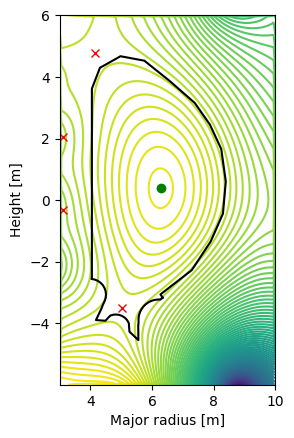

psi_relchange: 1.0674071850427045
bndry_relchange: 0.02
bndry_change: 10.0


psi_relchange: 0.023335135765002662
bndry_relchange: 1.0
bndry_change: 51740.515701907105


psi_relchange: 0.007615303190415192
bndry_relchange: 10.343452880071174
bndry_change: -57278.138288120965


2023-06-16 09:32:24,944 INFO [spdm] : Solve G-S equation Done
2023-06-16 09:32:24,949 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/modules/Equilibrium.py:33:update: Update Equlibrium at time=0.0
2023-06-16 09:32:24,951 INFO [spdm] : Update Equilibrium: EquilibriumFreeGS Done


In [7]:
eq = tok.equilibrium.update(
    core_profiles_1d=tok.core_profiles.profiles_1d.current,
    lcfs=True,
    wall=tok.wall,
    pf_active=tok.pf_active,
    # Ip=1.5e6, beta_p=0.6056,
    tolerance=1.0e-2,)


In [8]:
display(eq)

2023-06-16 09:32:28,178 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:110:__init__: Create MagneticCoordSystem.
2023-06-16 09:32:28,180 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:126:__init__: COCOS=5


2023-06-16 09:32:29,482 ERROR [spdm] /home/salmon/workspace/fytok/python/fytok/modules/Equilibrium.py:82:plot: Plot boundary failed! 


In [9]:
tok

2023-06-16 09:33:07,819 ERROR [spdm] /home/salmon/workspace/fytok/python/fytok/modules/Equilibrium.py:82:plot: Plot boundary failed! 


In [15]:
j_tor=tok.equilibrium.time_slice.current.profiles_2d[0].j_tor.__array__()       
plt.imshow(j_tor, origin="lower", aspect="auto")

RuntimeError: Error when evaluating dpressure_dpsi(psi) !

2023-06-16 08:48:42,706 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:110:__init__: Create MagneticCoordSystem.
2023-06-16 08:48:42,708 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:126:__init__: COCOS=5


2023-06-16 08:48:43,899 ERROR [spdm] /home/salmon/workspace/fytok/python/fytok/modules/Equilibrium.py:157:plot: Plot boundary failed! 


<Axes: >

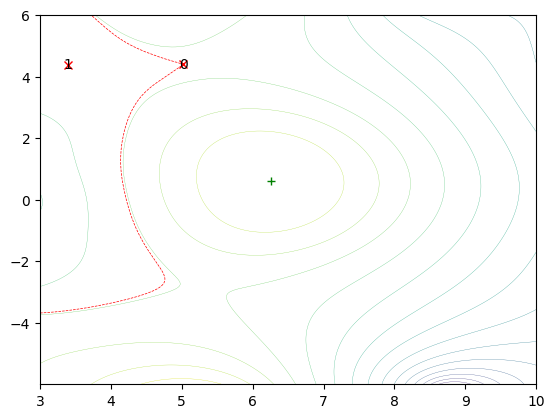

In [5]:
tok.equilibrium.plot()

In [12]:
np.min(psi2)

-4.044116600907502

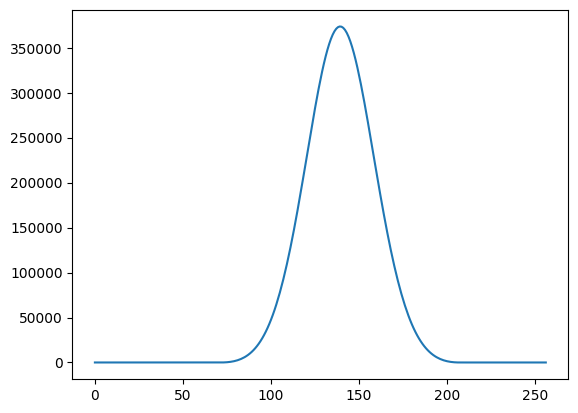

In [11]:
j_tor = tok.equilibrium.time_slice[-1].profiles_2d[0].j_tor.__array__()
plt.plot(j_tor[60, :])


In [13]:


psi_norm = tok.core_profiles.profiles_1d[-1].grid.psi_norm
R0 = tok.core_profiles.profiles_1d[-1].grid.r0
B0 = tok.core_profiles.profiles_1d[-1].grid.b0
pprime = tok.core_profiles.profiles_1d[-1].pprime.pullback(psi_norm)

ffprime = tok.core_profiles.profiles_1d[-1].ffprime.pullback(psi_norm)

profiles = freegs.jtor.ProfilesPprimeFfprime(pprime, ffprime, R0*B0)


ValueError: x must be increasing if s > 0